# Lindi FU SID: 20656439

# IMDB Review Project

In [19]:
# Load libraries
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup

from keras.utils import to_categorical
import random
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

In [20]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/lindy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lindy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lindy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import Data

In [21]:
# Read data
train_pos = pd.read_csv('/Users/lindy/Documents/HKUST/machine_learning/project/data/train_pos.csv')
train_neg = pd.read_csv('/Users/lindy/Documents/HKUST/machine_learning/project/data/train_neg.csv')
test_pos = pd.read_csv('/Users/lindy/Documents/HKUST/machine_learning/project/data/test_pos.csv')
test_neg = pd.read_csv('/Users/lindy/Documents/HKUST/machine_learning/project/data/test_neg.csv')

In [22]:
# Add one column "sentiment" to train and test data
train_pos["sentiment"] = "1"
train_neg["sentiment"] = "0"
test_pos["sentiment"] = "1"
test_neg["sentiment"] = "0"

In [23]:
# combine train data
train = [train_pos, train_neg]
train = pd.concat(train, ignore_index = True)

# combine test data
test = [test_pos, test_neg]
test = pd.concat(test, ignore_index = True)

In [71]:
# shuffle the data to get random order
train = train.sample(frac = 1)

In [72]:
test = test.sample(frac = 1)

In [73]:
train.head()

,Unnamed: 0,Review,sentiment
12182,12182,skinni seem thi much older thought wa still co...,1
19024,6524,wonder thi movi never saw light day time wa re...,0
2148,2148,first think anoth disney movi might good kid m...,1
9612,9612,found highli interest film actual manag bridg ...,1
11785,11785,reign success due power work adam sandler chea...,1


# Text normalization

In [74]:
# Tokenization of text
tokenizer = ToktokTokenizer()
# Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

# Data cleaning

## Remove html strips and noisy text

In [75]:
# Remove html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# Apply function on Review column
train["Review"] = train["Review"].apply(denoise_text)

## Remove special characters

In [76]:
# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# Apply function on Review column
train['Review'] = train['Review'].apply(remove_special_characters)

## Text stemming

In [77]:
# Define function for stemming the text
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
# Apply function on Review column
train['Review'] = train['Review'].apply(stemmer)

## Remove stop words

In [78]:
from nltk.tokenize.toktok import ToktokTokenizer

In [79]:
stop = set(stopwords.words('english'))
print(stop)

# Removing the stopwords
def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on Review column
train['Review'] = train['Review'].apply(remove_stopwords)

{'will', 'you', 'at', 'my', "won't", 'your', 'shan', 'itself', 'shouldn', 'some', 'did', 'there', 'her', 'had', "aren't", "it's", 'just', 'on', 'very', 'y', 'above', "weren't", 'in', 'didn', 'wasn', 'between', 'this', 'other', 'each', 'for', 'aren', 'd', 'being', 'ain', 'why', 'an', 'was', 'themselves', 'below', 'own', 'weren', 'which', "haven't", 'before', 'more', 'further', 'or', 'out', "you'll", 'but', 'too', 'isn', 'how', "she's", 'about', 'he', 'him', 'these', 'should', 'whom', 'all', 'haven', 'can', 'who', 'through', 'couldn', "wouldn't", "couldn't", 'against', 'wouldn', 'than', "wasn't", 'while', 'does', 'most', 'doesn', "mustn't", 'its', "you've", 'them', 'yourselves', 'has', 'no', 'nor', 't', 'm', "shan't", 'when', 'll', 'be', 'they', 'won', 'that', 'off', 'as', 'me', 'same', 'o', 'because', "shouldn't", 'by', "hadn't", "isn't", 'been', 'with', 'their', "you'd", 'we', 'i', 'few', 'up', 'myself', 'if', 'both', 'yours', 'yourself', 'herself', 'after', 're', "that'll", 'until', '

## Bags of words model

### BOW model is used to convert text documents to numerical vectors or bag of words

In [80]:
# Define a function cv to count vectorizer for bag of words
cv = CountVectorizer(min_df = 0, max_df = 1, binary = False, ngram_range = (1, 3))

# transformed train reviews
cv_train_review = cv.fit_transform(train["Review"])
#transformed test reviews
cv_test_review = cv.transform(test["Review"])

print('BOW_cv_train:',cv_train_review.shape)
print('BOW_cv_test:',cv_test_review.shape)

BOW_cv_train: (25000, 4138346)
BOW_cv_test: (25000, 4138346)


# Linear support vector machines for bag of words

In [81]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
# Train a linear SVM model
svm = SGDClassifier(loss='hinge', max_iter = 1000,random_state = 42)
# fit the SVM model for bag of words
svm_bow = svm.fit(cv_train_review, train["sentiment"])
print(svm_bow)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


## Linear SVM model performance on test set

In [82]:
# Predict the model for bag of words
svm_bow_predict = svm.predict(cv_test_review)
print(svm_bow_predict)

['0' '0' '0' ... '0' '0' '0']


## Model Accuracy

In [83]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
# Accuracy score for bag of words
svm_bow_score = accuracy_score(test["sentiment"], svm_bow_predict)
print("svm_bow_score :", svm_bow_score)

svm_bow_score : 0.52932


## Classification Report

In [84]:
# Classification report for bag of words 
svm_bow_report = classification_report(test["sentiment"], svm_bow_predict, target_names=['Positive','Negative'])
print(svm_bow_report)

              precision    recall  f1-score   support

    Positive       0.52      0.88      0.65     12500
    Negative       0.60      0.17      0.27     12500

    accuracy                           0.53     25000
   macro avg       0.56      0.53      0.46     25000
weighted avg       0.56      0.53      0.46     25000



## Multinomial Naive Bayes model for bag of words

In [85]:
from sklearn.naive_bayes import MultinomialNB
# Training the model
multi_bayes = MultinomialNB()
# Fit the multi-normial Naive Bayes model for bag of words
multi_bayes_bow = multi_bayes.fit(cv_train_review,train["sentiment"])
print(multi_bayes_bow)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


## Multinomial Naive Bayes model performance on test set

In [86]:
# Predict the model for bag of words
multi_bayes_predict = multi_bayes.predict(cv_test_review)
print(multi_bayes_predict)

['1' '1' '1' ... '1' '1' '1']


## Model Accuracy

In [87]:
# Accuracy score for bag of words
multi_bayes_score = accuracy_score(test["sentiment"], multi_bayes_predict)
print("multi_bayes_score :", multi_bayes_score)

multi_bayes_score : 0.54568


## Classification Report

In [88]:
# Classification report for bag of words 
multi_bayes_report = classification_report(test["sentiment"], multi_bayes_predict, target_names=['Positive','Negative'])
print(multi_bayes_report)

              precision    recall  f1-score   support

    Positive       0.60      0.28      0.38     12500
    Negative       0.53      0.81      0.64     12500

    accuracy                           0.55     25000
   macro avg       0.56      0.55      0.51     25000
weighted avg       0.56      0.55      0.51     25000



## Word cloud for positive reviews

<function matplotlib.pyplot.show(*args, **kw)>

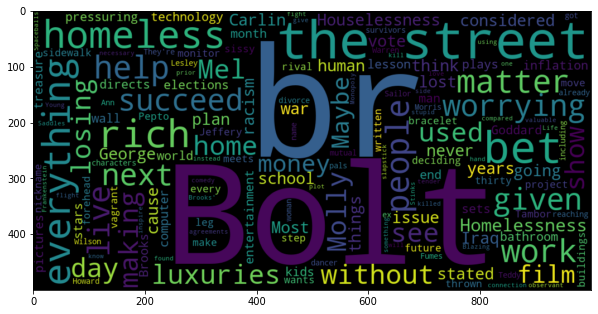

In [89]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (10, 10))
positive_text = train_pos["Review"][1]
WC = WordCloud(width = 1000,height = 500, max_words = 500, min_font_size = 5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation = 'bilinear')
plt.show

## Word cloud for negative reviews

<function matplotlib.pyplot.show(*args, **kw)>

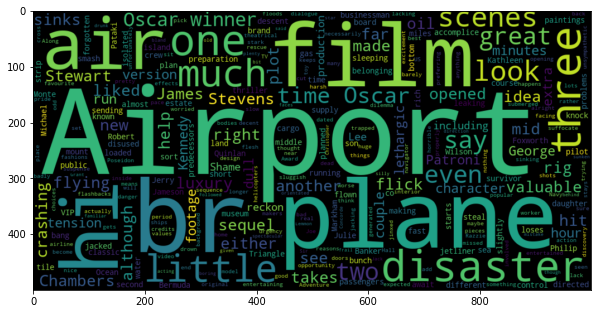

In [90]:
plt.figure(figsize = (10, 10))
negative_text = train_neg["Review"][1]
WC = WordCloud(width = 1000, height = 500, max_words = 500, min_font_size = 5)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words,interpolation = 'bilinear')
plt.show

## Conclusion

By comparing the classification report of Linear Support Vector Machine and Multinomial Naive Bayes model,  we observe that the SVM model performs slightly better than Multinomial Naive Bayes. 
The model performance can be improved by data pre-processing step as well as data cleaning. 

## Github link